In [116]:
import pandas as pd
from sklearn.model_selection import train_test_split
import re
from tqdm import tqdm_notebook
import os
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

In [12]:
def create_dir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

create_dir('./data/opennmt/sport_ru_news_vs_news_1')
create_dir('./data/opennmt/sport_ru_news_vs_news_2')

In [107]:
dtypes_br = {
    'match_id': 'int64',
    'team1': 'object',
    'team2': 'object',
    'name': 'object',
    'match_time': 'int64',
    'type': 'category',
    'minute': 'int64',
    'content': 'object',
    'message_time':'int64'
}

dtypes_ns = {
    'id': 'int64',
    'name': 'object',
    'ctime': 'int64',
    'body': 'object',
    'match_id': 'int64',
}

news = pd.read_csv('data/ods_match_news.csv',
                 header=0, 
                 usecols=dtypes_ns.keys(), 
                 skipinitialspace=True,
                 skip_blank_lines=True,
                 encoding='utf-8')
def clean_news_text(text):
    return  re.sub("(&#(?:\d)*;)", "", re.sub("<.*?>", "", text)).replace("\n","").replace("\r","").replace("\x96","")

news = news.dropna()
news.body = news.body.apply(clean_news_text)
news.body.replace(' ', np.nan, inplace=True)
news = news.dropna()
news = news[news.match_id != 787015]

In [108]:
news.shape
news.drop(news.columns.difference(['body']), 1, inplace=True)
news.shape

(92985, 1)

In [109]:
news.head()

,body
0,Главный тренер ЦСКА Зико поделился мыслями о п...
1,Сегодня на Sports.ru дебютируют текстовые онла...
2,Сегодня на Sports.ru дебютируют текстовые онла...
3,Полузащитник Астон Виллы Стилян Петров поделил...
4,Главный тренер сборной России и Челси Гус Хидд...


In [113]:
lens = []
for i,row in news.iterrows():
    lens.append(len(row.body))

(array([5.7526e+04, 2.7986e+04, 5.3440e+03, 7.8200e+02, 1.7000e+02,
        2.8900e+02, 1.3400e+02, 4.2000e+01, 4.8000e+01, 1.4400e+02,
        1.1600e+02, 4.7000e+01, 1.1000e+01, 7.2000e+01, 6.6000e+01,
        1.3000e+01, 1.0000e+00, 4.3000e+01, 6.5000e+01, 9.0000e+00,
        2.0000e+00, 1.9000e+01, 4.1000e+01, 1.0000e+00, 0.0000e+00,
        5.0000e+00, 7.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([    0. ,   746.7,  1493.4,  2240.1,  2986.8,  3733.5,  4480.2,
         5226.9,  5973.6,  6720.3,  7467. ,  8213.7,  8960.4,  9707.1,
        10453.8, 11200.5, 11947.2, 12693.9, 13440.6, 14187.3, 14934. ,
        15680.7, 16427.4, 17174.1, 17920.8, 18667.5, 19414.2, 20160.9,
        20907.6, 21654.3, 22401. ]),
 <a list of 30 Patch objects>)

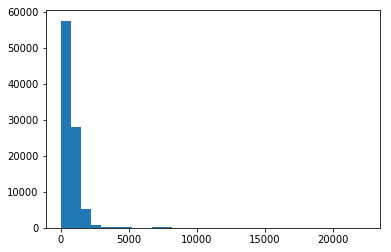

In [119]:
plt.hist(lens, bins=30)

### News vs news (split all news for 2 groups)

In [100]:
news_1, news_2 = train_test_split(news, test_size=0.5, random_state=42)
news_final = pd.concat([news_1.reset_index(), news_2.reset_index()], axis=1,ignore_index=True)
news_final.drop(news_final.columns.difference([1,3]), 1, inplace=True)
news_final.columns = ['source', 'target']
news_final.dropna(inplace=True)

In [101]:
news_final.head()

,source,target
0,Главный тренер СКА Вацлав Сикора прокомментиро...,Защитник «Барселоны» Жерар Пике высказался пос...
1,Главный тренер «Вашингтона» Брюс Будро после м...,Вратарь «Локомотива» Гильерме поделился ожидан...
2,Нападающий «Рубина» Владимир Дядюн высказал со...,Главный тренер сборной Испании Висенте Дель Бо...
3,Нападающий ЦСКА Симон Ялмарссон прокомментиров...,Форвард СКА Евгений Артюхин после победы над Ц...
4,Нападающий «Филадельфии» Майк Ричардс после че...,Почетный президент РФС Вячеслав Колосков проко...


In [102]:
news_final.shape

(46492, 2)

In [104]:
X_train_1, X_test_1 = train_test_split(news_final, test_size=0.1, random_state=42)
X_train_1, X_val_1 = train_test_split(X_train_1, test_size=0.11, random_state=42)
print("All: ", news_final.shape)
print("Len X_train: ", len(X_train_1))
print("Len X_val: ", len(X_val_1))
print("Len X_test: ", len(X_test_1))

All:  (46492, 2)
Len X_train:  37239
Len X_val:  4603
Len X_test:  4650


In [151]:
def create_dataset(X, type_ds, to_dir):
    assert type_ds in ['test','train', 'valid']
    create_dir(to_dir)
    count_lines = 0
    src_file = "%s/%s_src.txt"%(to_dir,type_ds)
    tgt_file = "%s/%s_tgt.txt"%(to_dir,type_ds)
    with(open(src_file, 'w')) as f_source:
        with(open(tgt_file, 'w')) as f_target:
            for i,row in tqdm_notebook(X.iterrows()):
                f_source.write(row['source'] + "\n")
                f_target.write(row['target'] + "\n")
                count_lines +=1
    print("Source file: ", src_file)
    print("Target file: ", tgt_file)
    print("Count lines: ",count_lines)

In [152]:
print("Build train dataset")
create_dataset(X_train_1, 'train', "./data/opennmt/sport_ru_news_vs_news_1")
print("Build test dataset")
create_dataset(X_test_1, 'test', "./data/opennmt/sport_ru_news_vs_news_1")
print("Build valid dataset")
create_dataset(X_val_1, 'valid', "./data/opennmt/sport_ru_news_vs_news_1")

Build train dataset



Source file:  ./data/opennmt/sport_ru_news_vs_news_1/train_src.txt
Target file:  ./data/opennmt/sport_ru_news_vs_news_1/train_tgt.txt
Count lines:  37239
Build test dataset



Source file:  ./data/opennmt/sport_ru_news_vs_news_1/test_src.txt
Target file:  ./data/opennmt/sport_ru_news_vs_news_1/test_tgt.txt
Count lines:  4650
Build valid dataset



Source file:  ./data/opennmt/sport_ru_news_vs_news_1/valid_src.txt
Target file:  ./data/opennmt/sport_ru_news_vs_news_1/valid_tgt.txt
Count lines:  4603


In [153]:
!wc -l ./data/opennmt/sport_ru_news_vs_news_1/train_src.txt
!wc -l ./data/opennmt/sport_ru_news_vs_news_1/train_tgt.txt
!wc -l ./data/opennmt/sport_ru_news_vs_news_1/test_src.txt
!wc -l ./data/opennmt/sport_ru_news_vs_news_1/test_tgt.txt
!wc -l ./data/opennmt/sport_ru_news_vs_news_1/valid_src.txt
!wc -l ./data/opennmt/sport_ru_news_vs_news_1/valid_tgt.txt

   37239 ./data/opennmt/sport_ru_news_vs_news_1/train_src.txt
   37239 ./data/opennmt/sport_ru_news_vs_news_1/train_tgt.txt
    4650 ./data/opennmt/sport_ru_news_vs_news_1/test_src.txt
    4650 ./data/opennmt/sport_ru_news_vs_news_1/test_tgt.txt
    4603 ./data/opennmt/sport_ru_news_vs_news_1/valid_src.txt
    4603 ./data/opennmt/sport_ru_news_vs_news_1/valid_tgt.txt


In [ ]:
! python ./OpenNMT/preprocess.py \
-train_src /data/denisogr/opennmt/sport_ru_news_vs_news_1/source/train_src.txt \
-train_tgt /data/denisogr/opennmt/sport_ru_news_vs_news_1/source/train_tgt.txt \
-valid_src /data/denisogr/opennmt/sport_ru_news_vs_news_1/source/valid_src.txt \
-valid_tgt /data/denisogr/opennmt/sport_ru_news_vs_news_1/source/valid_tgt.txt \
-save_data /data/denisogr/opennmt/sport_ru_news_vs_news_1/data/data \
-share_vocab \
-dynamic_dict \
-src_vocab_size 50000 \
-report_every 1000 \
-shard_size 10000 \
-src_seq_length 5000 \
-src_seq_length_trunc 2000 \
-tgt_seq_length 5000 \
-tgt_seq_length_trunc 2000

In [ ]:
! python ./OpenNMT/train.py \
-data "/data/denisogr/opennmt/sport_ru_news_vs_news_1/data/data" \
-save_model "/data/denisogr/opennmt/sport_ru_news_vs_news_1/model/model" \
-share_embeddings \
-batch_type tokens \
-batch_size 32 \
-valid_batch_size 2 \
-copy_attn \
-global_attention mlp \
-word_vec_size 128 \
-rnn_size 512 \
-layers 1 \
-encoder_type brnn \
-max_grad_norm 2 \
-dropout 0. \
-optim adagrad \
-adagrad_accumulator_init 0.1 \
-reuse_copy_attn \
-copy_loss_by_seqlength \
-bridge \
-seed 42 \
-gpu_ranks 0 \
-save_checkpoint_steps 10000 \
-train_steps 100000 \
-learning_rate 0.001 \
-report_every 1000 \
-valid_steps 20000 \
-layers 4 \
-learning_rate 0.01 \
-encoder_type transformer \
-decoder_type transformer \
-rnn_size 128 \
-world_size 1

In [ ]:
! python ./OpenNMT/translate.py \
-model "/data/denisogr/opennmt/sport_ru_news_vs_news_1/model/model_step_100000.pt" \
-src "/data/denisogr/opennmt/sport_ru_news_vs_news_1/source/test_src.txt" \
-tgt "/data/denisogr/opennmt/sport_ru_news_vs_news_1/source/test_tgt.txt" \
-output "/data/denisogr/opennmt/sport_ru_news_vs_news_1/source/test_result.txt" \
-beam_size 10 \
-dynamic_dict \
-share_vocab \
-batch_size 2 \
-batch_type sents \
-gpu 0 \
-seed 42

### Results

### News vs news (same news as source and target)

In [154]:
X_train_2, X_test_2 = train_test_split(news, test_size=0.1, random_state=42)
X_train_2, X_val_2 = train_test_split(X_train_2, test_size=0.11, random_state=42)
print("All: ", news.shape)
print("Len X_train: ", len(X_train_2))
print("Len X_val: ", len(X_val_2))
print("Len X_test: ", len(X_test_2))

All:  (92985, 1)
Len X_train:  74480
Len X_val:  9206
Len X_test:  9299


In [155]:
X_train_2.head()

,body
26824,Бывший полузащитник Зенита Вячеслав Булавин по...
50339,Бывший нападающий «Спартака» Валерий Рейнгольд...
38724,Во 2-м туре групповой стадии Лиги Европы «Руби...
45352,Главный тренер «Леванте» Хуан Игнасио Мартинес...
63631,Нападающий сборной Белоруссии Андрей Стась пос...


In [156]:
def create_dataset(X, type_ds, to_dir):
    assert type_ds in ['test','train', 'valid']
    create_dir(to_dir)
    count_lines = 0
    src_file = "%s/%s_src.txt"%(to_dir,type_ds)
    tgt_file = "%s/%s_tgt.txt"%(to_dir,type_ds)
    with(open(src_file, 'w')) as f_source:
        with(open(tgt_file, 'w')) as f_target:
            for i,row in tqdm_notebook(X.iterrows()):
                f_source.write(row['body'] + "\n")
                f_target.write(row['body'] + "\n")
                count_lines +=1
    print("Source file: ", src_file)
    print("Target file: ", tgt_file)
    print("Count lines: ",count_lines)

In [157]:
print("Build train dataset")
create_dataset(X_train_2, 'train', "./data/opennmt/sport_ru_news_vs_news_2")
print("Build test dataset")
create_dataset(X_test_2, 'test', "./data/opennmt/sport_ru_news_vs_news_2")
print("Build valid dataset")
create_dataset(X_val_2, 'valid', "./data/opennmt/sport_ru_news_vs_news_2")

Build train dataset



Source file:  ./data/opennmt/sport_ru_news_vs_news_2/train_src.txt
Target file:  ./data/opennmt/sport_ru_news_vs_news_2/train_tgt.txt
Count lines:  74480
Build test dataset



Source file:  ./data/opennmt/sport_ru_news_vs_news_2/test_src.txt
Target file:  ./data/opennmt/sport_ru_news_vs_news_2/test_tgt.txt
Count lines:  9299
Build valid dataset



Source file:  ./data/opennmt/sport_ru_news_vs_news_2/valid_src.txt
Target file:  ./data/opennmt/sport_ru_news_vs_news_2/valid_tgt.txt
Count lines:  9206


In [158]:
!wc -l ./data/opennmt/sport_ru_news_vs_news_2/train_src.txt
!wc -l ./data/opennmt/sport_ru_news_vs_news_2/train_tgt.txt
!wc -l ./data/opennmt/sport_ru_news_vs_news_2/test_src.txt
!wc -l ./data/opennmt/sport_ru_news_vs_news_2/test_tgt.txt
!wc -l ./data/opennmt/sport_ru_news_vs_news_2/valid_src.txt
!wc -l ./data/opennmt/sport_ru_news_vs_news_2/valid_tgt.txt

   74480 ./data/opennmt/sport_ru_news_vs_news_2/train_src.txt
   74480 ./data/opennmt/sport_ru_news_vs_news_2/train_tgt.txt
    9299 ./data/opennmt/sport_ru_news_vs_news_2/test_src.txt
    9299 ./data/opennmt/sport_ru_news_vs_news_2/test_tgt.txt
    9206 ./data/opennmt/sport_ru_news_vs_news_2/valid_src.txt
    9206 ./data/opennmt/sport_ru_news_vs_news_2/valid_tgt.txt


In [161]:
! head -n 1 "./data/opennmt/sport_ru_news_vs_news_2/train_src.txt"

Бывший полузащитник Зенита Вячеслав Булавин поделился ожиданиями от матча групповой стадии Лиги чемпионов ЦСКА  Лилль.У ЦСКА трудное положение: обязательно надо выигрывать у Лилля. Ведь завершающий матч предстоит против Интера, который умеет играть в Лиге чемпионов.Не знаю, как скажется на игре армейцев отсутствие Думбия, поскольку в последнее время забивает именно он. В то же время допускаю вариант, что Интер может досрочно решить свою задачу уже в этом туре,  приводит слова Булавин Спорт Уик-Энд.Напомним, матч 5-го тура группового этапа Лиги чемпионов ЦСКА  Лилль состоится сегодня в 21.00 в Лужниках.


In [162]:
! head -n 1 "./data/opennmt/sport_ru_news_vs_news_2/train_tgt.txt"

Бывший полузащитник Зенита Вячеслав Булавин поделился ожиданиями от матча групповой стадии Лиги чемпионов ЦСКА  Лилль.У ЦСКА трудное положение: обязательно надо выигрывать у Лилля. Ведь завершающий матч предстоит против Интера, который умеет играть в Лиге чемпионов.Не знаю, как скажется на игре армейцев отсутствие Думбия, поскольку в последнее время забивает именно он. В то же время допускаю вариант, что Интер может досрочно решить свою задачу уже в этом туре,  приводит слова Булавин Спорт Уик-Энд.Напомним, матч 5-го тура группового этапа Лиги чемпионов ЦСКА  Лилль состоится сегодня в 21.00 в Лужниках.


In [ ]:
! python ./OpenNMT/preprocess.py \
-train_src /data/denisogr/opennmt/sport_ru_news_vs_news_2/source/train_src.txt \
-train_tgt /data/denisogr/opennmt/sport_ru_news_vs_news_2/source/train_tgt.txt \
-valid_src /data/denisogr/opennmt/sport_ru_news_vs_news_2/source/valid_src.txt \
-valid_tgt /data/denisogr/opennmt/sport_ru_news_vs_news_2/source/valid_tgt.txt \
-save_data /data/denisogr/opennmt/sport_ru_news_vs_news_2/data/data \
-share_vocab \
-dynamic_dict \
-src_vocab_size 50000 \
-report_every 1000 \
-shard_size 10000 \
-src_seq_length 5000 \
-src_seq_length_trunc 2000 \
-tgt_seq_length 5000 \
-tgt_seq_length_trunc 2000

In [ ]:
! python ./OpenNMT/train.py \
-data "/data/denisogr/opennmt/sport_ru_news_vs_news_2/data/data" \
-save_model "/data/denisogr/opennmt/sport_ru_news_vs_news_2/model/model" \
-share_embeddings \
-batch_type tokens \
-batch_size 32 \
-valid_batch_size 2 \
-copy_attn \
-global_attention mlp \
-word_vec_size 128 \
-rnn_size 512 \
-layers 1 \
-encoder_type brnn \
-max_grad_norm 2 \
-dropout 0. \
-optim adagrad \
-adagrad_accumulator_init 0.1 \
-reuse_copy_attn \
-copy_loss_by_seqlength \
-bridge \
-seed 42 \
-gpu_ranks 0 \
-save_checkpoint_steps 10000 \
-train_steps 100000 \
-learning_rate 0.001 \
-report_every 1000 \
-valid_steps 20000 \
-layers 4 \
-learning_rate 0.01 \
-encoder_type transformer \
-decoder_type transformer \
-rnn_size 128 \
-world_size 1

In [ ]:
python ./OpenNMT/translate.py \
-model "/data/denisogr/opennmt/sport_ru_news_vs_news_2/model/model_step_100000.pt" \
-src "/data/denisogr/opennmt/sport_ru_news_vs_news_2/source/test_src.txt" \
-tgt "/data/denisogr/opennmt/sport_ru_news_vs_news_2/source/test_tgt.txt" \
-output "/data/denisogr/opennmt/sport_ru_news_vs_news_2/source/test_result.txt" \
-beam_size 10 \
-dynamic_dict \
-share_vocab \
-batch_size 2 \
-batch_type sents \
-gpu 0 \
-seed 42 \
-report_rouge

### Result